# Деревья решений

## Решение задачи классификации

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Создаём сложный датасет
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=4,
    n_clusters_per_class=1,
    class_sep=0.5,
    random_state=42
)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Инициализация дерева
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
print(f"Accuracy: {clf.score(X_test, y_test):.2f}")

Accuracy: 0.66


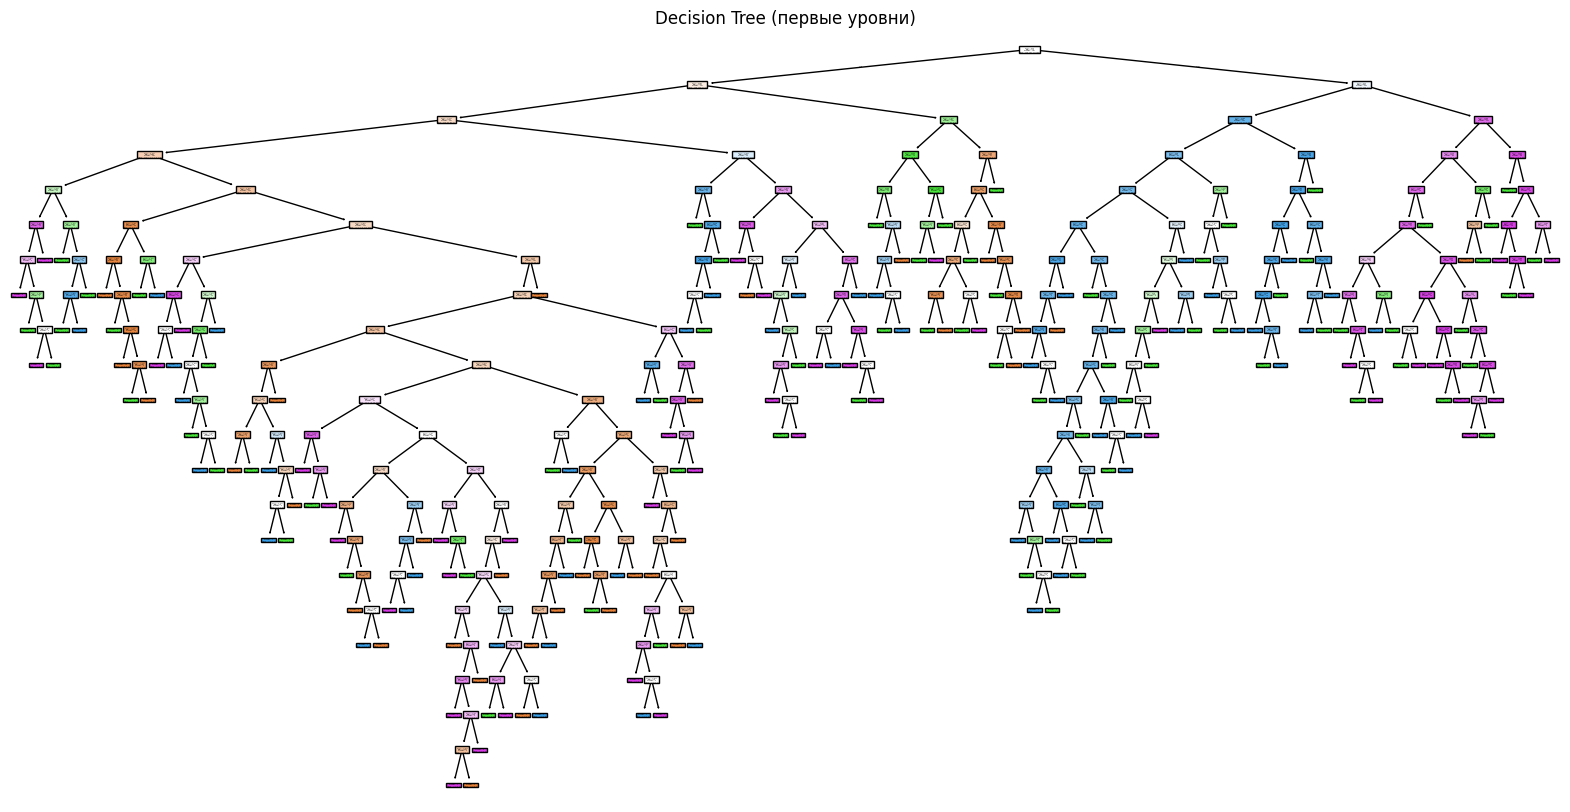

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

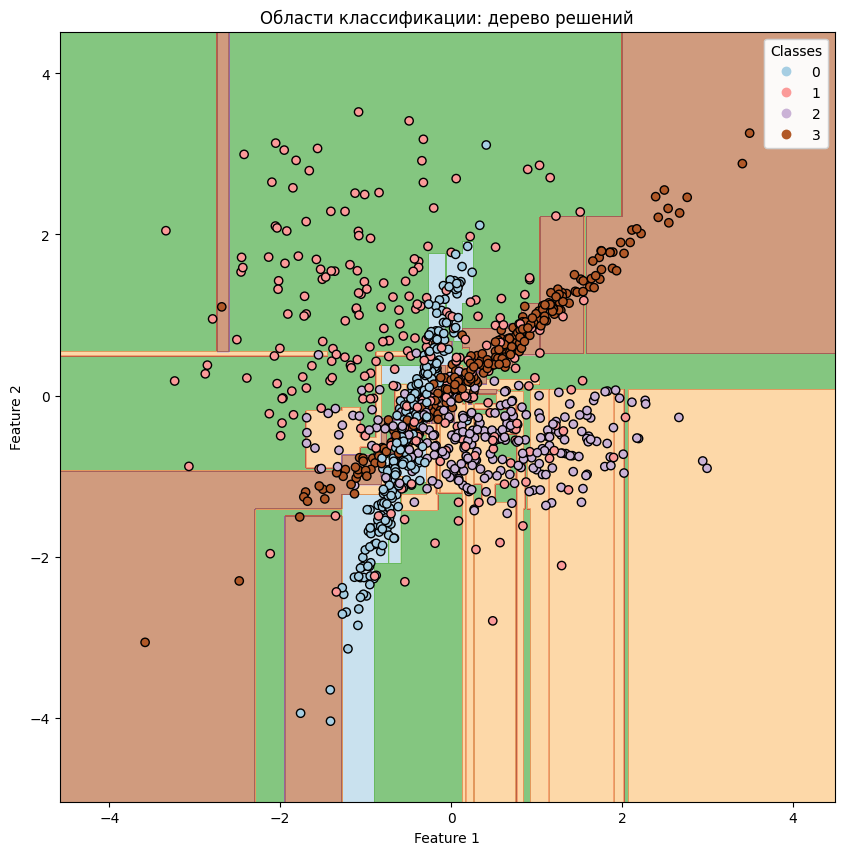

In [ ]:
# Визуализация областей классификации
def plot_decision_boundaries(model, X, y, ax=None, title="Decision Boundaries"):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.Paired)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.add_artist(legend)

# Построение графика областей классификации
plt.figure(figsize=(10, 10))
plot_decision_boundaries(clf, X, y)
plt.title("Области классификации: дерево решений")
plt.show()

## Pre-pruning

In [ ]:
clf_prepruned = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
clf_prepruned.fit(X_train, y_train)

print(f"Accuracy (pre-pruned): {clf_prepruned.score(X_test, y_test):.2f}")

Accuracy (pre-pruned): 0.68


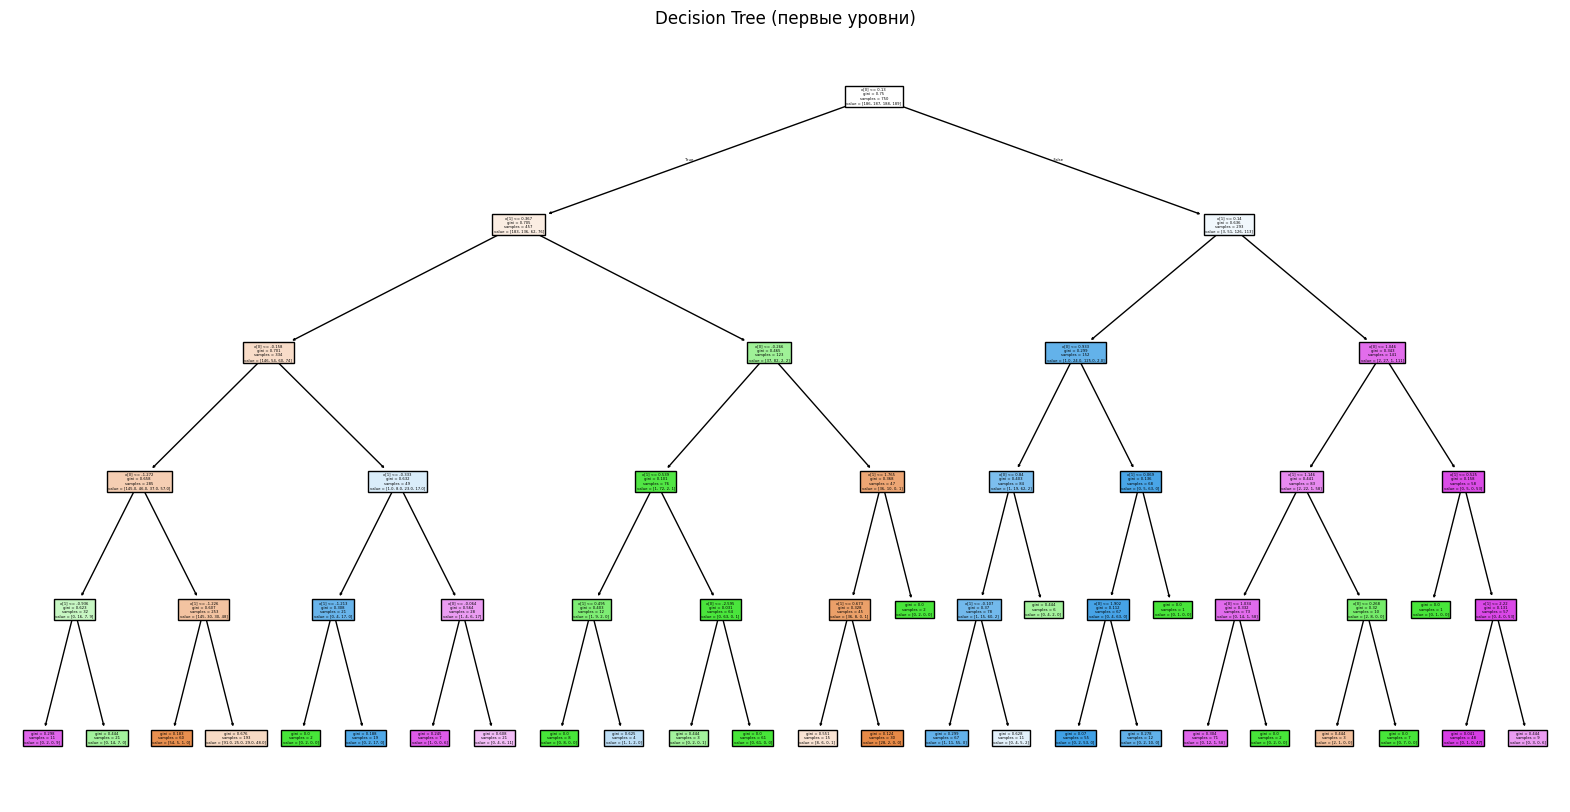

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(clf_prepruned, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

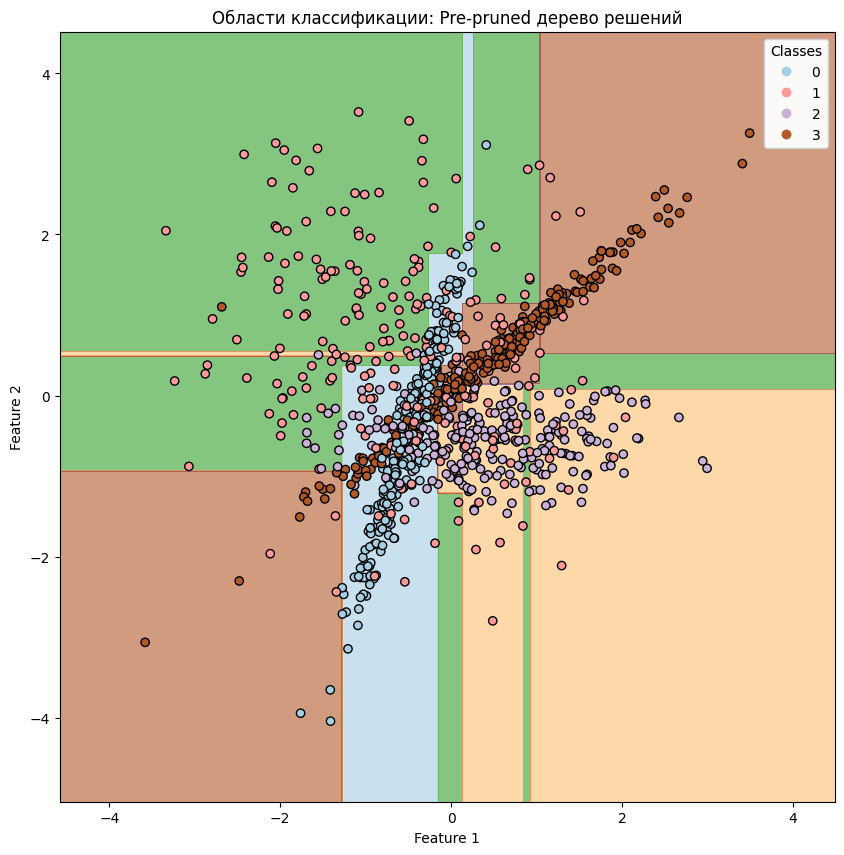

In [ ]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(clf_prepruned, X, y)
plt.title("Области классификации: Pre-pruned дерево решений")
plt.show()

## Post-pruning

In [ ]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Тестируем несколько деревьев с разными alpha
clfs = [DecisionTreeClassifier(random_state=42, ccp_alpha=alpha).fit(X_train, y_train) for alpha in ccp_alphas]

# Оцениваем на тесте
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Выбираем лучшее
best_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_index]
print(f"Best alpha: {best_alpha:.4f}, Accuracy: {test_scores[best_index]:.2f}")

Best alpha: 0.0070, Accuracy: 0.73


In [ ]:
clf_postpruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha).fit(X_train, y_train)

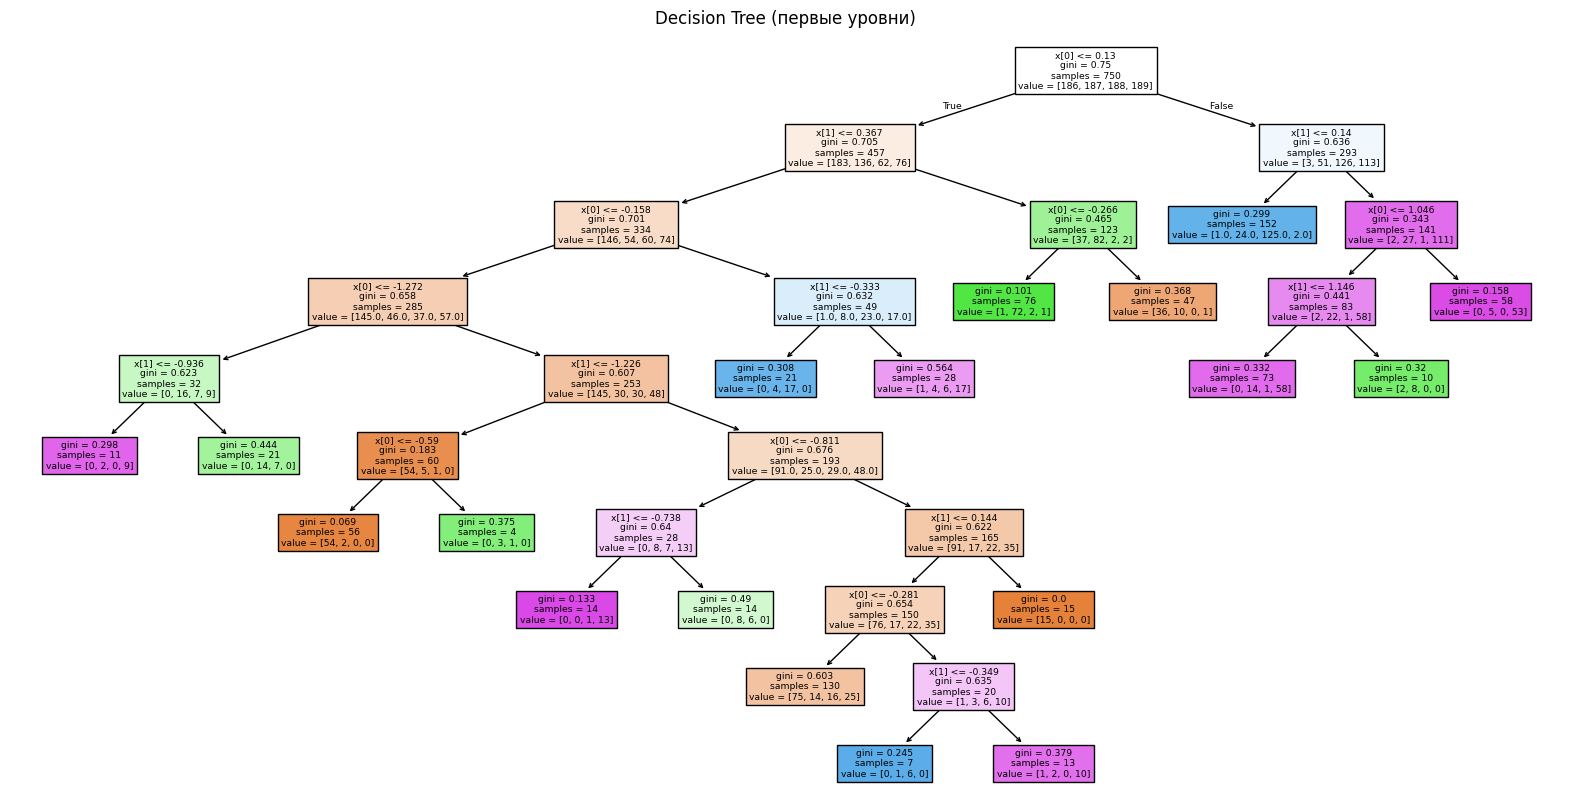

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(clf_postpruned, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

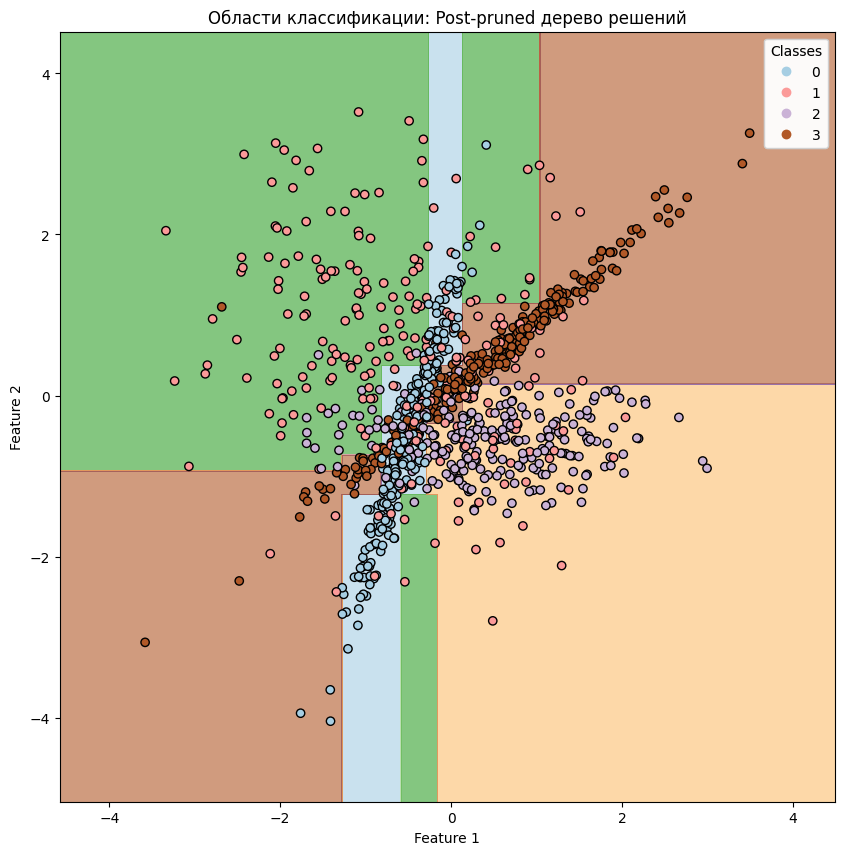

In [ ]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(clf_postpruned, X, y)
plt.title("Области классификации: Post-pruned дерево решений")
plt.show()

## Поиск по сетке лучших гиперпараметров (поиск лучшей регуляризации)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [1, 2, 5, 10, 15, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30, 50]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")

Best params: {'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_leaf': 1}
Best accuracy: 0.74


In [ ]:
best_clf = grid_search.best_estimator_

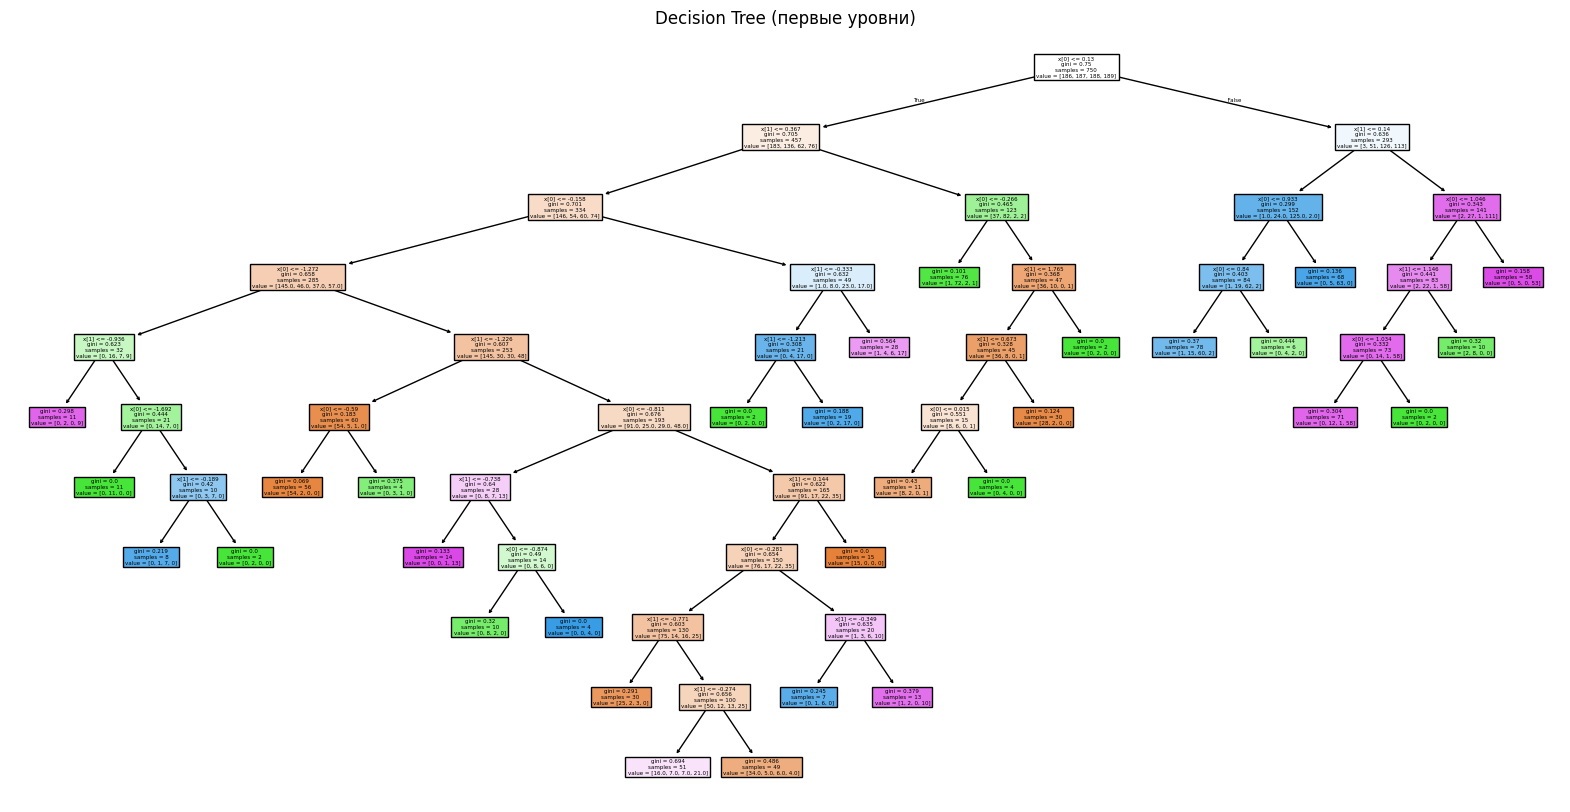

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

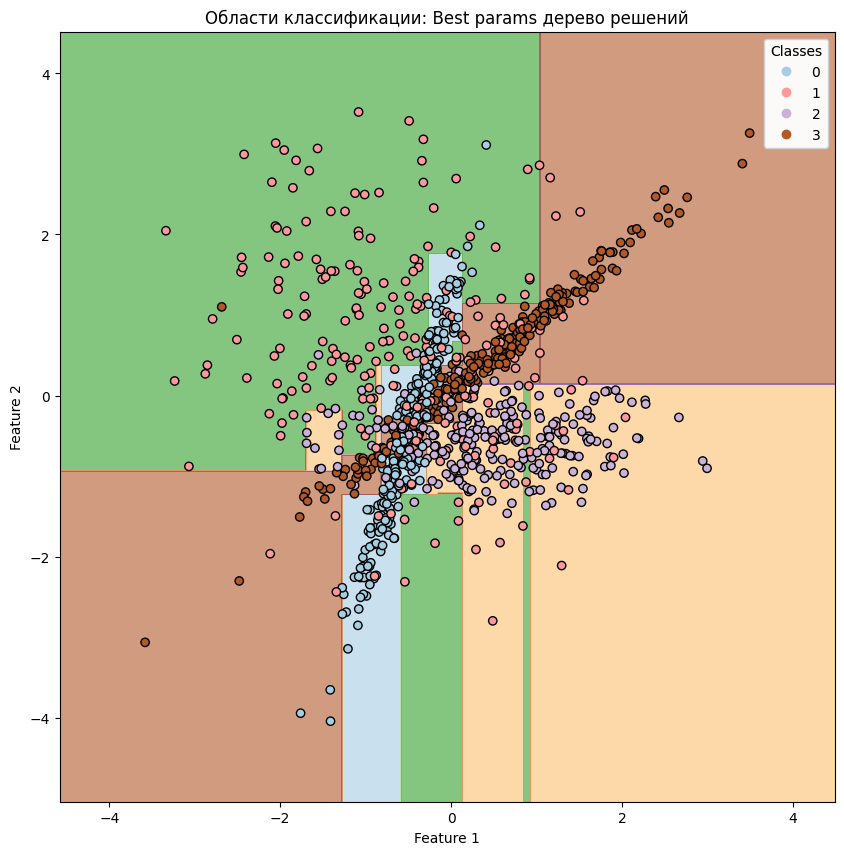

In [ ]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(best_clf, X, y)
plt.title("Области классификации: Best params дерево решений")
plt.show()

## Работа с пропусками

In [ ]:
import pandas as pd

# Создаем копию и добавим пропуски
X_missing = X.copy()
rng = np.random.RandomState(42)
missing_mask = rng.rand(*X_missing.shape) < 0.1
X_missing[missing_mask] = np.nan

# Обучим дерево на данных с пропущенными значениями после простой обработки
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_missing)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_imputed, y, stratify=y, random_state=42)

clf_postpruned.fit(X_train_m, y_train_m)

print(f"Accuracy with missing values: {clf_postpruned.score(X_test_m, y_test_m):.2f}")

Accuracy with missing values: 0.63


In [ ]:
pd.DataFrame(X_missing).sample(10, random_state=40)

,0,1
204,-0.175861,NaN
71,0.033544,0.778521
594,1.284577,-0.716192
672,2.174701,-0.528312
14,1.382030,NaN
64,NaN,0.053602
340,-0.686766,-1.184090
135,0.439899,0.302905
350,1.741449,NaN
976,-0.469268,-0.036559


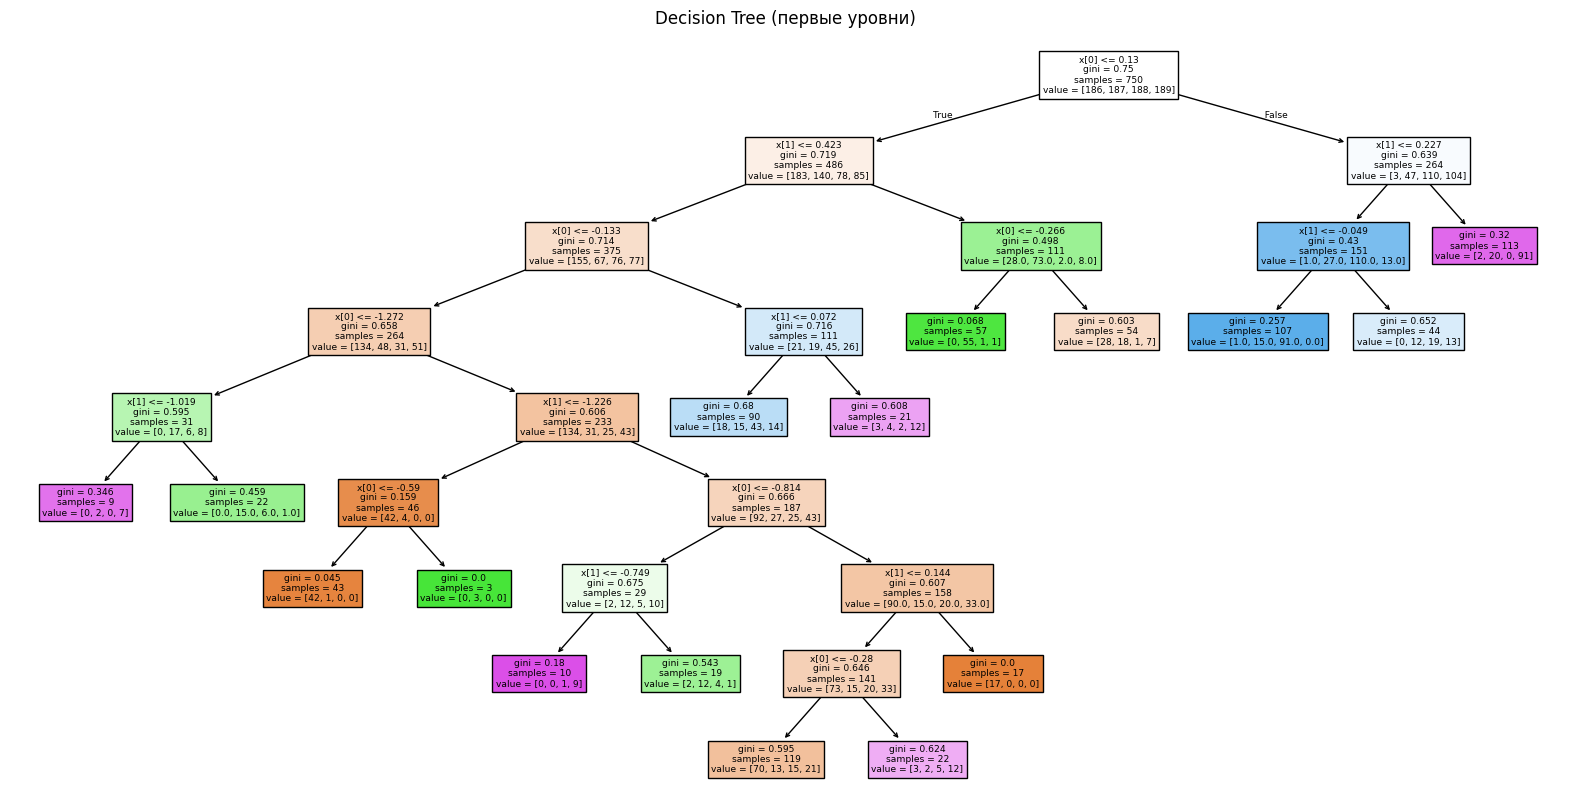

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(clf_postpruned, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

## Неустойчивость дерева

Сначала сравним устойчивости дерева решений и SVM, решив задачу классификации. Для примера возьмем датасет из Kaggle под названием Титаник, где суть заключаетсвя в том, что за фичи отвечают различные критерий, например возраст или класс билета, а за таргет бинарная переменная Survived.
https://www.kaggle.com/competitions/titanic/data?select=test.csv

In [79]:
import pandas as pd
train_dt = pd.read_csv("train.csv")
train_dt.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Так как датасет соревновательный используем только файл train.csv, почистим его от ненужной информации и заполним пропуски

In [80]:
train_dt.isnull().sum()
train_dt=train_dt.drop(columns=['PassengerId','Name','Ticket','Cabin', 'Embarked'])
train_dt['Age'] = train_dt['Age'].fillna(train_dt['Age'].median())

In [81]:
train_dt['Age'] = train_dt['Age'].fillna(train_dt['Age'].median())
train_dt['Sex'] = train_dt['Sex'].map({'male': 0, 'female': 1})

Инициализируем модели классификации для дерева решений и SVM.
Далее мы их обучим и посмотрим результаты на тестовых выборках данных, используя метрику Accuracy из confusion matrix

In [82]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
X = train_dt.drop(columns = ['Survived'])
y = train_dt['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
clf1 = DecisionTreeClassifier(random_state = 42)
clf1.fit(X_train, y_train)
y_pred_clf1 = clf1.predict(X_test)
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Initial Tree accuracy:", accuracy_score(y_test, y_pred_clf1))
print("Initial SVM accuracy:", accuracy_score(y_test, y_pred_svm))

Initial Tree accuracy: 0.7597765363128491
Initial SVM accuracy: 0.6536312849162011


In [83]:
# Изменим данные: удалим 5 случайных строк
X_train_mod = X_train.drop(X_train.sample(10, random_state=1).index)
y_train_mod = y_train.loc[X_train_mod.index]


После небольшого изменений тренировочного датасета получим измененные метрики, где виден результат устойчивости обеих моделей.


In [84]:
clf1.fit(X_train_mod, y_train_mod)
svm.fit(X_train_mod, y_train_mod)

print("Modified Tree accuracy:", accuracy_score(y_test, clf1.predict(X_test)))
print("Modified SVM accuracy:", accuracy_score(y_test, svm.predict(X_test)))

Modified Tree accuracy: 0.7877094972067039
Modified SVM accuracy: 0.659217877094972


Для второго сравнения используем также датасет с Kaggle, где суть заключается в наличии характеристик дома(фичи) и его итоговой ценой(таргет).
https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction

In [89]:
from sklearn.tree import DecisionTreeRegressor
clf2 = DecisionTreeRegressor(random_state = 42)
sal_df = pd.read_csv("Real estate.csv")
sal_df = sal_df.dropna()
sal_df.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


Как и в прошлом сравнении инициализируем нужные модели для решения задачи регрессии и обучаем их.
В качестве метрик используем MSE и R^2.

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#sal_df = sal_df[['YearsExperience', 'Salary']]
X = sal_df.drop(columns = ['Y house price of unit area'])
y = sal_df['Y house price of unit area']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
lin_reg = LinearRegression()
clf2.fit(X_train, y_train)
lin_reg.fit(X_train, y_train)
y_pred_clf2 = clf2.predict(X_test)
y_pred_lin = lin_reg.predict(X_test)
print("tree MSE:", mean_squared_error(y_test,y_pred_clf2))
print("tree R^2:", r2_score(y_test,y_pred_clf2))
print("Lin reg MSE:", mean_squared_error(y_test, y_pred_lin))
print("Lin R^2:", r2_score(y_test,y_pred_lin))

tree MSE: 53.89337349397591
tree R^2: 0.6787466883184802
Lin reg MSE: 54.60196067337693
Lin R^2: 0.6745228670350882


In [93]:
#удаляем случайные 150 объектов из тренировочной выборки
X_train_mod = X_train.drop(X_train.tail(150).index)
y_train_mod = y_train.loc[X_train_mod.index]

После изменения тренировочного датасета получаем новые метрики, где виден результат устойчивости обеих моделей.

In [94]:
clf2.fit(X_train_mod, y_train_mod)
lin_reg.fit(X_train_mod, y_train_mod)
y_pred_clf22 = clf2.predict(X_test)
y_pred_lin2 = lin_reg.predict(X_test)

print("tree MSE:", mean_squared_error(y_test,y_pred_clf22))
print("tree R^2:", r2_score(y_test,y_pred_clf22))
print("Lin reg MSE:", mean_squared_error(y_test, y_pred_lin2))
print("Lin R^2:", r2_score(y_test,y_pred_lin2))

tree MSE: 63.319638554216866
tree R^2: 0.6225576121655707
Lin reg MSE: 54.46960446479863
Lin R^2: 0.6753118298995515
